Since having twins a few years ago, my free time has been unsurprisingly limited. The time I get to spend with my young children is precious, but I’ve struggled to be intentional about carving out space for my own interests. This past year I only read one book (not counting audio), Allen Downey’s Probably Overthinking It. I’m a big fan.

In the new year, I’m setting a small goal: write one blog post each quarter and read at least one more book than this year. Not particularly lofty in the grand scheme of things, but this post is my attempt to get the ball rolling.

# Distributional Models: What are they?

Distributional models are exactly what they sound like: models for distributions. In a standard regression, we only model the expected value of the target as a function of our features. With a distributional model, we go a step further and let the variance, and sometimes the shape or skew, change with those same features. The point isn’t just to get a prediction, but to quantify the uncertainty around it in a structured, data-driven way.

# Why would I use them?

Because I find it satisfying to tinker with them. In a way that may be a bit indulgent as an analogy, building a model reminds me of playing with my favorite childhood toy: LEGO. Defining the relationships between predictors and distributional parameters, then stacking those pieces together, gives the model a kind of bespoke, home-made feeling.

But that's just me. Why might YOU be interested in building one?

A couple of use cases come to mind. If you’re embedding a predictive model inside a larger simulation or optimization pipeline (sometimes called a digital twin), you’ll almost always need a variance component. In those settings, it’s useful to model not just the mean prediction, but how the uncertainty itself changes with your inputs.

Another use case is when you’re tackling a regression problem but actually care about the probability distribution over outcomes. Being able to answer questions like, “What is the probability that our monthly sales exceed $X?” can be incredibly valuable for planning and decision-making.

In [1]:
import numpy as np
import polars as pl
import pymc as pm
import pytensor as pt
import arviz as az
from scipy.special import expit, logit
from scipy.stats import norm, bernoulli, betabinom, poisson
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from typing import Tuple

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # was getting a weird warning. Chat-GPT told me to do this.

The first step of any model-building process is data ~cleaning simulating~ synthetic data. Anyone familiar with Richard McElreath’s Statistical Rethinking will understand why: simulation lets us test whether a proposed model can recover the parameters that generated the data in the first place. I find this especially valuable in distributional modeling, where assumptions about variance and scale matter as much as assumptions about the mean.

In the setup below, we imagine some variable `y` that we want to model. We already have a set of predicted means, `y_pred`, from an existing model. We also observe a covariate x that we believe influences the variability, or predictive accuracy, around those means. The following code simulates data for this scenario, and plots the residuals against `x`.

In [2]:
def simulate_synthetic_data(
    n:int, 
    y_pred_mean:float=0.0, 
    y_pred_sd:float=1.0, 
    x_mean:float=0.0, 
    x_sd:float=1.0, 
    intercept:float=0.0, 
    beta:float=1.0
) -> pl.DataFrame:
    """
    Simulate data from a normal model with variance depending on x
    """
    # Simulate x variable
    x = norm.rvs(loc=x_mean, scale=x_sd, size=n)

    # Simulate y predictions
    y_pred = norm.rvs(loc=y_pred_mean, scale=y_pred_sd, size=n)

     # Simulate y variable - standard deviation depends on x
    y_sd = np.exp(intercept + beta * x) 
    y = norm.rvs(loc=y_pred, scale=y_sd)

    return  pl.DataFrame({
        'x':x, 'y': y, 'y_pred': y_pred
    })

# Simulate 1000 observations
N = 1000
df = simulate_synthetic_data(N)
x = df['x'].to_numpy(); y = df['y']

<Axes: title={'center': 'Residual by x'}, xlabel='x', ylabel='Residual (y - y_pred)'>

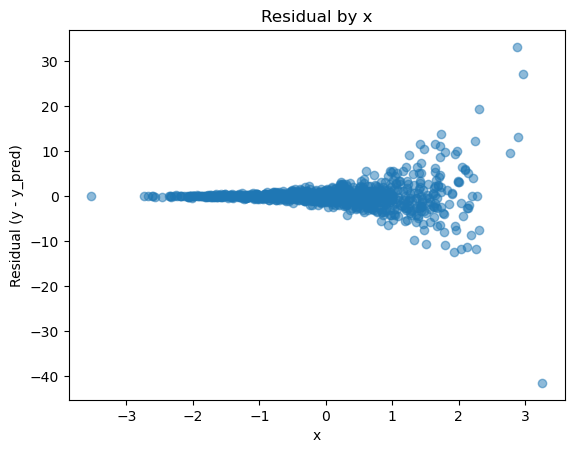

In [3]:
def plot_residual_by_x(
    df: pl.DataFrame, 
    x_col: str, 
    y_pred_col: str, 
    y_col: str, 
    ax=None
):
    """
    Plot residuals (y - y_pred) vs. a predictor x.
    """
    if ax is None:
        fig, ax = plt.subplots()

    df = df.with_columns(resid = pl.col(y_col) - pl.col(y_pred_col))
    ax.scatter(df[x_col].to_numpy(), df["resid"].to_numpy(), alpha=0.5)
    ax.set_title("Residual by x")
    ax.set_xlabel(x_col)
    ax.set_ylabel("Residual (y - y_pred)")
    return ax


plot_residual_by_x(df, 'x', 'y_pred', 'y')

This is a classic case of heteroskedasticity, the conditional variance of the residuals increases as x increases even though the model remains unbiased on average. I’m not concerned with the statistical significance of regression coefficients here, but heteroskedasticity can still create practical issues. In many applications, a model is only as good as its worst prediction, and understanding how large that error could become is essential.

3.0589007412130345


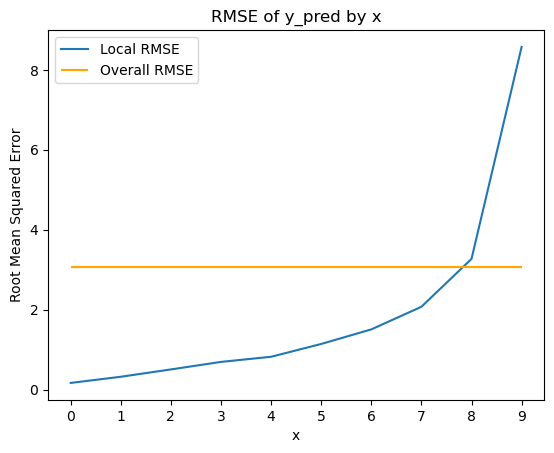

In [4]:
def plot_mse_by_x(df:pl.DataFrame, x_col:str, y_pred_col:str, y_col:str, bins:int=10) -> None:
    """
    Function to plot the Mean Squared Error over x.
    """

    plot_df = (
        df
        .with_columns([
           pl.col(x_col).qcut(bins, labels=[str(i) for i in range(bins)], allow_duplicates=True).alias("x_bin"),
            (((pl.col(y_pred_col) - pl.col(y_col)) ** 2)).alias("sqrd_error")
        ])
        .group_by('x_bin')
        .agg(
            pl.col("sqrd_error").mean().alias("mse")
        )
        .with_columns(
            rmse = pl.col('mse') ** (1/2)
        )
        .sort('x_bin')
    )

    # compute global loss
    y_pred = df[y_pred_col].to_numpy()
    y = df[y_col].to_numpy()
    rmse = np.sqrt(np.mean((y - y_pred) **2))
    print(rmse)

    plt.plot(
        plot_df['x_bin'].to_numpy(),
        plot_df['rmse'].to_numpy(),
        label = "Local RMSE"
    )
    plt.title(f'RMSE of {y_pred_col} by {x_col}')
    plt.hlines(
        np.repeat(rmse, 2),
        xmin = plot_df['x_bin'].to_numpy().min(), 
        xmax = plot_df['x_bin'].to_numpy().max(),
        colors = 'orange',
        label = "Overall RMSE"
    )
    plt.xlabel(x_col)
    plt.ylabel('Root Mean Squared Error')
    plt.legend()

plot_mse_by_x(df, 'x', 'y_pred', 'y')

Because we simulated the data ourselves, we know the underlying data-generating process. In principle, modeling it should be straightforward. A well-specified model ought to recover the parameters that produced the data. To test this, I fit a Bayesian model in PyMC that estimates the intercept and beta terms controlling how the residual variance changes with x.

In [ ]:
def linear_variance_model(x: np.ndarray, y_pred:np.ndarray, y:np.ndarray) -> pm.Model:
    """
    Define a linear variance distributional model using pymc.
    """
    with pm.Model() as model:

        # data
        x_data = pm.Data('x_data', x)
        y_pred_data = pm.Data('y_pred_data', y_pred)
        y_data = pm.Data('y_data', y)

        # priors
        intercept = pm.Normal('intercept', 0, 1)
        beta = pm.Normal('beta', 0, 1)

        y_sigma = pm.math.exp(intercept + beta * x_data)

        # likelihood
        y_obs = pm.Normal(
            'y_obs',
            mu = y_pred_data,
            sigma = y_sigma,
            observed = y_data
        )

        # Predictive Node (Not Observed)
        y_new = pm.Normal(
            "y_new",
            mu=y_pred_data,
            sigma=y_sigma,
            shape=x_data.shape,
        )
        
    return model

model = linear_variance_model(
    df['x'].to_numpy(), 
    df['y_pred'].to_numpy(), 
    df['y'].to_numpy()
)

with model:
    idata = pm.sample()
    
az.summary(idata)

c:\Users\mason\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, y_new]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.001,0.023,-0.044,0.042,0.001,0.000,1392.0,1849.0,1.01
beta,1.024,0.021,0.982,1.061,0.000,0.000,2052.0,2730.0,1.00
y_new[0],0.935,0.090,0.772,1.105,0.001,0.002,7886.0,2418.0,1.00
y_new[1],-0.136,0.279,-0.678,0.376,0.004,0.005,6027.0,2596.0,1.00
y_new[2],-0.694,3.605,-7.794,5.785,0.046,0.061,6095.0,2780.0,1.00
...,...,...,...,...,...,...,...,...,...
y_new[995],1.833,0.582,0.743,2.929,0.007,0.010,6696.0,3027.0,1.00
y_new[996],0.597,0.477,-0.272,1.523,0.006,0.009,6358.0,2796.0,1.00
y_new[997],0.744,0.933,-1.008,2.435,0.011,0.020,6666.0,2281.0,1.00
y_new[998],-0.536,0.186,-0.900,-0.190,0.002,0.004,8162.0,2644.0,1.00


Unsurprisingly, we find the intercept is nearly 0, and the beta is close to 1.

Now lets test our model on a real-world problem. After a considerable amount of time thinking on an application, I ended up deciding that this type of model could be well suited to estimate the precision of weather forecasts from initial forecast to the target day. I hear Seattle gets a lot of rain, so its precipitation forecasts should be perfect to test our model against.

I use the (open-meteo)[https://open-meteo.com/en/docs/previous-runs-api] previous model runs API to get historical precipitation forecasts for 7 days before each target day for the last two years. I also use the same source to pull observed precipitation sums for the target days. The Open Meteo API documentation was very helpful in developing the following code.

In [6]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime, timezone, timedelta

def setup_open_meteo_client():
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	return openmeteo_requests.Client(session = retry_session)

def fetch_daily_precipitation_sum(lat, lon, start, end, openmeteo):

	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": lon,
		"start_date": start,
		"end_date": end,
		"hourly": "precipitation",
	}
	response = openmeteo.weather_api(url, params=params)[0]

	hourly = response.Hourly()
	hourly_precipitation = hourly.Variables(0).ValuesAsNumpy()

	start = datetime.fromtimestamp(hourly.Time(), timezone.utc)
	end = datetime.fromtimestamp(hourly.TimeEnd(), timezone.utc)
	freq = timedelta(seconds = hourly.Interval())

	return (
		pl.select(
			hour = pl.datetime_range(start, end, freq, closed = "left"),
			precip_obs = hourly_precipitation
		)
		.with_columns(
			date = pl.col("hour").dt.date()
		)
		.group_by('date')
		.agg(
			precip_obs = pl.col('precip_obs').sum()
		)
	)


def fetch_daily_precipitation_forcasts(lat, lon, start, end, days_ahead, openmeteo):
	url = "https://previous-runs-api.open-meteo.com/v1/forecast"
	params = {
		"latitude": lat,
		"longitude": lon,
		"hourly": ["precipitation"] + [f"precipitation_previous_day{i}" for i in range(1, days_ahead + 1)],
		"start_date": start,
		"end_date": end,
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation: {response.Elevation()} m asl")
	print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	precip_pred = [hourly.Variables(i).ValuesAsNumpy() for i in range(days_ahead+1)]

	start_ts = datetime.fromtimestamp(hourly.Time(), timezone.utc)
	end_ts = datetime.fromtimestamp(hourly.TimeEnd(), timezone.utc)
	freq = timedelta(seconds = hourly.Interval())

	return (
		pl.DataFrame(    [
			pl.Series(f"precip_pred{i}", x)
			for i, x in enumerate(precip_pred)
		])
		.with_columns(
			hour = pl.datetime_range(start_ts, end_ts, freq, closed = "left")
		)
		.with_columns(
			date = pl.col("hour").dt.date()
		)
		.group_by('date')
		.agg([
			pl.col(f'precip_pred{i}').sum()
			for i in range(days_ahead + 1)
		])
	)


# Seattle
lat = 47.6062
lon = -122.3321
start = "2023-01-01"
end = "2025-12-03"
days_ahead = 7

def build_precipitation_data(lat, lon, start, end, days_ahead):
	openmeteo = setup_open_meteo_client()
	obs = fetch_daily_precipitation_sum(lat, lon, start, end, openmeteo)
	pred = fetch_daily_precipitation_forcasts(lat, lon, start, end, days_ahead, openmeteo)

	return obs.join(pred, on = ['date'], how = 'inner')


data = build_precipitation_data(lat, lon, start, end, days_ahead).drop_nans()


Coordinates: 47.59556198120117°N -122.32443237304688°E
Elevation: 59.0 m asl
Timezone difference to GMT+0: 0s


After downloading the data, we need to format the data set so that it mirrors our initial simulated data. In the following table, the `days_out` column will represent our `x` variable, the `precip_pred` will be our `y_pred`, and `precip_obs` the `y`.

In [7]:
model_data = (
    data
    .unpivot(
        index = ['date','precip_obs'],
        value_name = 'precip_pred'
    )
    .with_columns(
        days_out = pl.col('variable').str.replace('precip_pred','').cast(pl.Int32),
        resid = pl.col('precip_obs') - pl.col('precip_pred')
    )
    .select('date','days_out','precip_pred','precip_obs','resid')
)
model_data

date,days_out,precip_pred,precip_obs,resid
date,i32,f32,f32,f32
2024-01-26,0,0.7,7.6,6.900001
2024-01-27,0,15.7,33.0,17.299999
2024-01-28,0,20.299999,26.200001,5.900002
2024-01-29,0,0.0,0.8,0.8
2024-01-30,0,0.2,1.0,0.8
…,…,…,…,…
2025-11-29,7,0.6,0.0,-0.6
2025-11-30,7,5.5,0.0,-5.5
2025-12-01,7,0.0,0.2,0.2


Before modeling, lets analyze the data so we have a better understanding of what we are working with. Plotting the predicted precipitation mean squared error against days out is consistent with our hypothesis that the model performance is worse the further out it is being made. But lets dig a bit deeper.

4.366771


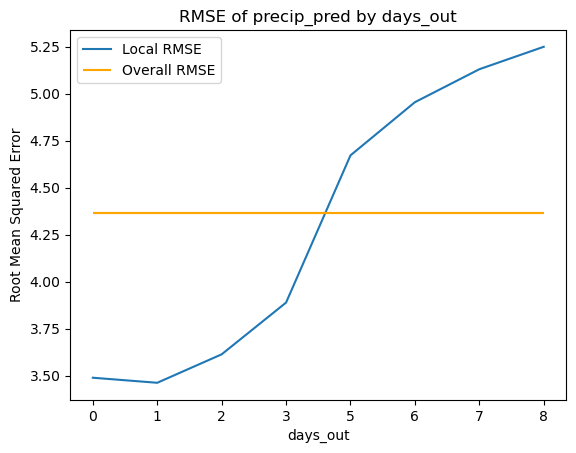

In [8]:
plot_mse_by_x(model_data, 'days_out', 'precip_pred', 'precip_obs')


The following residuals by days out scatter plot suggests a potential bias in the predictions, particularly at day 0 and days 5 through 7, but the KDE plot unveils a concentration around 0 with an apparent right skew.  

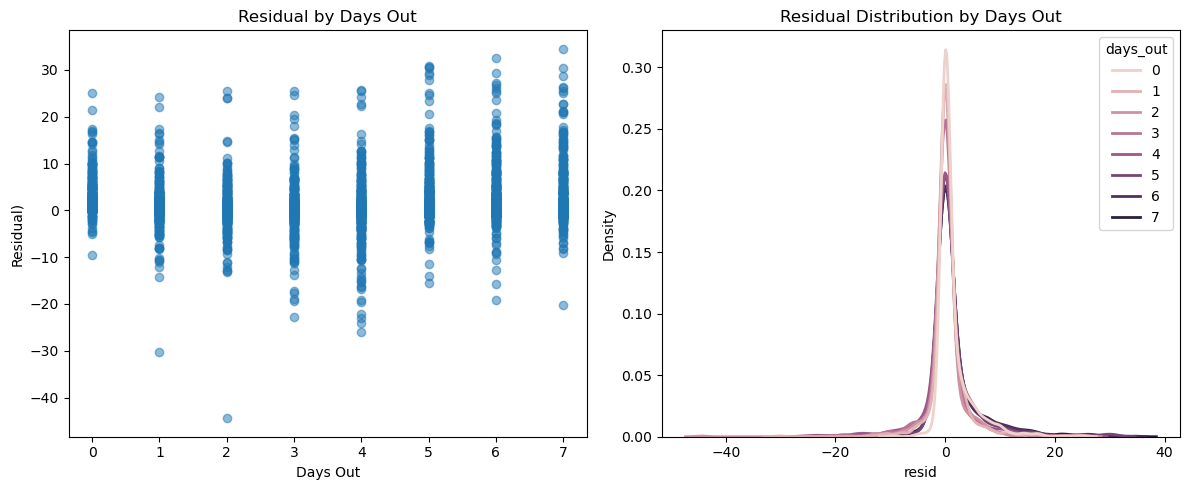

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_residual_by_x(model_data, 'days_out', 'precip_pred','precip_obs', ax=axes[0])
axes[0].set_title("Residual by Days Out")
axes[0].set_xlabel('Days Out')
axes[0].set_ylabel('Residual)')

sns.kdeplot(
    data=model_data,
    x="resid",
    hue="days_out",
    linewidth=2,
    common_norm=False,
    ax=axes[1]
)
axes[1].set_title("Residual Distribution by Days Out")

plt.tight_layout()
plt.show()

The following summary table confirms what we see above. Why might the residuals have a positive skew? There are several possible explanations. First, precipitation is bounded below at zero: negative errors have a natural limit, while positive errors do not, which naturally skews any error metric. Second, weather models may be conservative when predicting extreme precipitation, under-predicting heavy rain is often more palatable than dramatically over-predicting it. Lastly, many observations simply have zero rainfall. When both the prediction and the outcome are zero, residuals cluster at zero. But on days with actual rainfall, under-predictions can be much larger than over-predictions, because errors cannot go below zero but can extend far above it. This asymmetry creates a right-skewed residual distribution and pushes the mean residual above zero even when the median remains near zero. A quick query confirms this pattern.

In [10]:
(
    model_data
    .group_by('days_out')
    .agg(
        resid_median = pl.col('resid').median(),
        resid_mean = pl.col('resid').mean(),
        resid_sd = pl.col('resid').std(),
        resid_mse = (pl.col('resid')**pl.lit(2)).mean(),
        resid_mae = pl.col('resid').abs().mean()
    )
    .sort('days_out')
)

days_out,resid_median,resid_mean,resid_sd,resid_mse,resid_mae
i32,f32,f32,f32,f32,f32
0,0.0,1.445133,3.177733,12.171504,1.603835
1,0.0,0.567699,3.417537,11.984616,1.536726
2,0.0,0.260619,3.606383,13.054735,1.489233
3,0.0,0.179793,3.88706,15.119277,1.74646
4,0.0,0.125959,4.673016,21.820738,2.138938
5,0.0,1.556932,4.706409,24.541651,2.171976
6,0.0,1.687168,4.847357,26.308746,2.362389
7,0.0,1.784513,4.939613,27.548275,2.370944


In [11]:
(
    model_data
    .with_columns(
        both_are_zero = (pl.col('precip_obs') == pl.lit(0)) & (pl.col('precip_pred') == pl.lit(0))
    )
    .select(
        pl.col('both_are_zero').mean().alias('proportion_both_are_zero')
    )
)

proportion_both_are_zero
f64
0.417404


Back to the regularly scheduled programming. We’ll fit the distributional model to the weather data and then check the posterior trace to confirm that the sampler cooperated.

In [233]:
x = model_data['days_out'].to_numpy()
y_pred = model_data['precip_pred'].to_numpy()
y = model_data['precip_obs'].to_numpy()

weather_model = linear_variance_model(x, y_pred, y)

with weather_model:
    idata = pm.sample()

c:\Users\mason\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, y_new]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


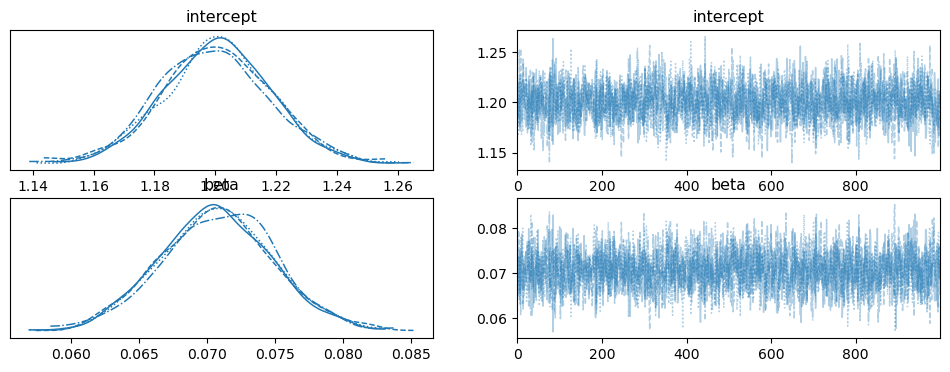

In [234]:
az.plot_trace(idata, var_names=['intercept','beta']);

In [235]:
az.summary(idata, var_names=['intercept','beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.200,0.018,1.167,1.235,0.0,0.0,1678.0,2541.0,1.0
beta,0.071,0.004,0.062,0.078,0.0,0.0,1755.0,2910.0,1.0


No real surprises in the posterior summary. The positive posterior mean (and the fully positive 94% HDI) suggests that forecast uncertainty does shrink as we get closer to the date of interest. With the model now fit, we can generate predictions for the entire distribution of rainfall at a given expected value.

In a fully Bayesian workflow, we'd propagate the entire posterior and draw predictive samples across chains and draws. However, this isn’t a post about Bayesian workflow best practices, so to keep things focused, I’m going to use posterior mean parameters to generate illustrative predictive distributions rather than working with the full posterior each time.

The plotting functions below overlay the model’s predicted distribution on top of the empirical histogram. Because the raw data at a single predicted value can be sparse, I include a bw parameter (“bandwidth”). This collects observed precipitation values within a window centered on the target prediction, giving us a practical sample size for comparison.

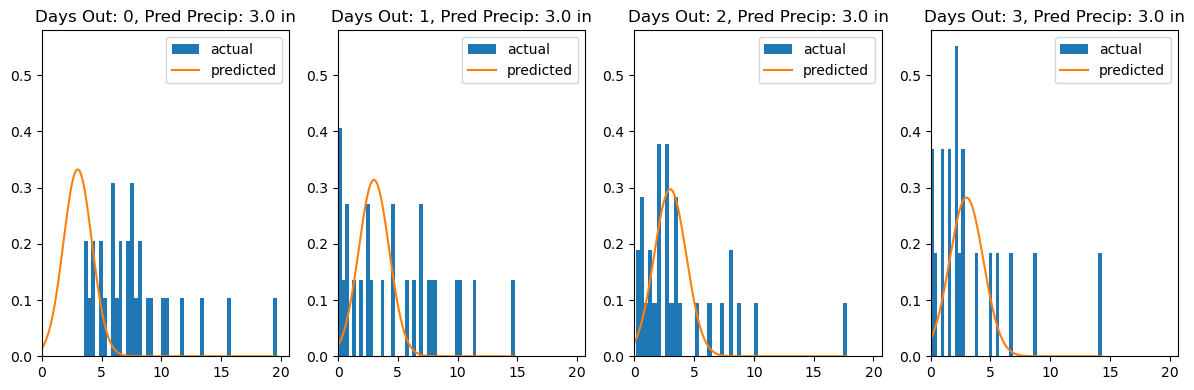

In [ ]:
def linear_variance_distribution(idata, y_pred, x):
    params = az.summary(idata, var_names=['intercept','beta'])['mean']
    sigma = params['intercept'] + params['beta'] * x
    return norm(y_pred, sigma)

def observed_rainfall(model_data, y_pred, x, bw):
    return (
        model_data
        .filter(
            (pl.col("precip_pred") >= y_pred - bw/2) & 
            (pl.col("precip_pred") <= y_pred + bw/2)
        )
        .filter(pl.col("days_out") == pl.lit(x))
       ['precip_obs']
    )

def plot_observed_vs_predicted(idata, model_data, y_pred, x, bw, title=None, dist_func=linear_variance_distribution):

    dist = dist_func(idata, y_pred, x)
    observed = observed_rainfall(model_data, y_pred, x, bw)
    plt.hist(observed, bins=50, density=True, label='actual')
    x_vals = np.arange(0, observed.max(), 0.1)
    plt.plot(x_vals, dist.pdf(x_vals), label="predicted")
    if title:
        plt.title(title)
    plt.legend();

# plot_observed_vs_predicted(idata, model_data, y_pred=5.0, x=3, bw=1.0)

max_pred_days_out = 4
y_pred_new = np.repeat(3.0, max_pred_days_out)
x_new = np.arange(max_pred_days_out)

fig, axes = plt.subplots(1, len(x_new), figsize=(12, 4))
for idx, (x_val, y_pred_val) in enumerate(zip(x_new, y_pred_new)):
    plt.sca(axes[idx])
    plot_observed_vs_predicted(
        idata,
        model_data,
        y_pred=float(y_pred_val),
        x=int(x_val),
        bw=1.0,
        title=f"Days Out: {x_val}, Pred Precip: {y_pred_val} mm"
    )

# align y-axis across subplots
ymax = max(ax.get_ylim()[1] for ax in axes)
xmax = max(ax.get_xlim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, ymax)
    ax.set_xlim(0, xmax)

plt.tight_layout()


I have to admit, the graphs above make it pretty clear that this model isn’t doing the job. That’s not because anything “broke,” but because a normal distribution centered on the forecast isn’t appropriate for precipitation. A normal distribution has support over all real numbers, while rainfall has a hard boundary at zero. We’re forcing the model to put probability mass on negative rainfall, which is fundamentally incompatible with the data-generating process.

So what should we use instead?

Let’s go back to the structure of the problem. Daily precipitation is really the combination of two events:

1. Does it rain at all? (a Bernoulli / logistic event)
2. If it rains, how much? (a continuous, positive-valued amount)

If it doesn’t rain, the total is zero. If it does, the total must come from a distribution with positive support and right skew. This is exactly the situation where a hurdle model makes sense: a Bernoulli model for “any rain?” paired with a distribution like Gamma or LogNormal for the amount conditional on rain. Both are well-behaved choices that naturally capture skew, scale, and positivity.

I mentioned at the beginning of this post that I’m aiming to write one blog entry per quarter next year. So I’m going to do myself a favor and leave the hurdle model implementation for the next installment. Future me can take it from here, and hopefully future you will come back to see how it turns out.